In [1]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import zipfile

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS


sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
## data extraction
zip_path = "Data-20240401.zip"

with zipfile.ZipFile(zip_path, 'r') as zip:
    zip.extractall()

FF5 = pd.read_csv('FF5_2000_2022.csv')
CRSP = pd.read_csv('CRSP_2000_2022.csv')
PS = pd.read_csv('PS_2000_2022.csv')
HXZ5 = pd.read_csv('HXZ5_2000_2022.csv')

In [3]:
# Data preparation, define df = dataframe with all the factors
df = (FF5
            .merge(HXZ5, on='YYYYMM')
            .drop(columns=['R_MKT','R_F','RF'])
            .merge(PS, on='YYYYMM',how='left')
            .set_index('YYYYMM')
)
exog_vars = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'AggLiq', 'eq8', 'LIQ_V']
df.tail()

,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V
YYYYMM,,,,,,,,,,,,
202208,-3.77,1.51,0.31,-4.80,1.30,1.4291,2.7381,-2.7978,-3.5470,NaN,NaN,NaN
202209,-9.35,-1.00,0.03,-1.50,-0.85,-1.6943,-0.2182,1.1517,1.7172,NaN,NaN,NaN
202210,7.83,1.87,8.05,3.07,6.56,4.6904,7.4110,5.3826,-0.9359,NaN,NaN,NaN
202211,4.60,-2.68,1.39,6.02,3.11,-2.3226,2.1779,2.3981,1.2883,NaN,NaN,NaN
202212,-6.41,-0.13,1.36,0.08,4.18,0.2797,3.8672,-0.5108,-0.3618,NaN,NaN,NaN


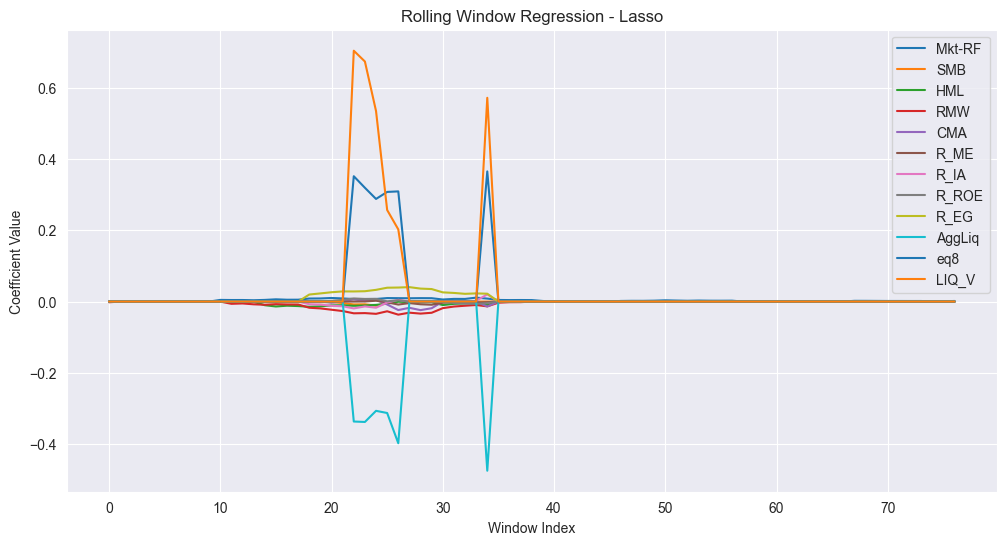

In [4]:
from sklearn.linear_model import LassoCV

# Data preparation
y = CRSP.loc['MthRet'].set_index(CRSP.loc['YYYYMM'])
exog = df.loc[y.index, exog_vars]

# Rolling window regression
window_size = 60
alpha = 0.001
n_periods = len(y)
n_windows = n_periods - window_size + 1
coefficients = []

for i in range(n_windows):
    X_train = exog.iloc[i:i+window_size]
    y_train = y.iloc[i:i+window_size]
    
    # Fit LassoCV model
    model = LassoCV(alpha_ = alpha)
    model.fit(X_train, y_train)
    
    # Store coefficients
    coefficients.append(model.coef_)

# Convert coefficients to DataFrame
coefficients_df = pd.DataFrame(coefficients, columns=exog_vars)

# Plot coefficients
coefficients_df.plot(figsize=(12, 6))
plt.xlabel('Window Index')
plt.ylabel('Coefficient Value')
plt.title('Rolling Window Regression - Lasso')
plt.legend(loc='upper right')
plt.show()


In [5]:
coefficients_df.tail()

,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V
72,1.597317e-03,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
73,1.619080e-03,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
74,5.458308e-19,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
75,0.000000e+00,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
76,1.748989e-03,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
